#  Les évolutions de l'utilisation du vélo à Aix

## 1 - Import et préparation des données

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np

from datetime import date, time, datetime, timedelta
from dateutil.relativedelta import relativedelta
import locale
locale.setlocale(locale.LC_TIME,'')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose

### Mairie - mesure des passages toutes les heures

In [3]:
data_mairie_1h = pd.read_csv('./data_mairie/data_velo_1h.csv',sep=';',encoding='latin-1')

In [4]:
#data_mairie_1h.rename(columns = {'Time':'date', 'Avenue Schuman':'schuman', 'EDCompact Casino':'europe', 'Av des belges gauche Vélo':'belges_dir_gare', 'av des belges droite Vélo':'belges_dir_rotonde'}, inplace=True)
data_mairie_1h.rename(columns = {'Time':'date', 'Avenue Schuman':'Av.Schuman', 'EDCompact Casino':'Av.Europe', 'Av des belges gauche Vélo':'Av.Belges-dir.Gare', 'av des belges droite Vélo':'Av.Belges-dir.Rotonde'}, inplace=True) 

In [5]:
#Convertir la date en format date (en modifiant les strings non reconnus sur les noms de mois)
data_mairie_1h['date'] = data_mairie_1h['date'].str.replace("é", "e")
data_mairie_1h['date'] = data_mairie_1h['date'].str.replace("janv.", "jan.")
data_mairie_1h['date'] = pd.to_datetime(data_mairie_1h['date'])

In [6]:
data_mairie_1h.head()

,date,Av.Schuman,Av.Europe,Av.Belges-dir.Gare,Av.Belges-dir.Rotonde
0,2019-09-18 02:00:00,NaN,NaN,NaN,2.0
1,2019-09-18 11:00:00,NaN,NaN,NaN,0.0
2,2019-09-18 12:00:00,NaN,NaN,NaN,2.0
3,2019-09-18 13:00:00,NaN,NaN,NaN,29.0
4,2019-09-18 14:00:00,NaN,NaN,NaN,20.0


In [7]:
data_mairie_1h = data_mairie_1h.set_index('date')

### Mairie - mesure des passages toutes les 15mn 

In [8]:
data_mairie_15mn = pd.read_csv('./data_mairie/data_velo_15mn.csv',sep=';',encoding='latin-1')

In [9]:
data_mairie_15mn.rename(columns = {'Time':'date', 'Avenue Schuman':'Av.Schuman', 'EDCompact Casino':'Av.Europe', 'Av des belges gauche Vélo':'Av.Belges-dir.Gare', 'av des belges droite Vélo':'Av.Belges-dir.Rotonde'}, inplace=True)  

In [10]:
#Convertir la date en format date (en modifiant les strings non reconnus sur les noms de mois)
data_mairie_15mn['date'] = data_mairie_15mn['date'].str.replace("é", "e")
data_mairie_15mn['date'] = data_mairie_15mn['date'].str.replace("janv.", "jan.")
data_mairie_15mn['date'] = pd.to_datetime(data_mairie_15mn['date'])

In [99]:
data_mairie_15mn = data_mairie_15mn.set_index('date')

### ADAVA : comptages des vélos pendant 1h par mois sur 16 points de la ville

In [11]:
data_a = pd.ExcelFile('./Comptage Cycliste Janvier 2020.xls')

sheet_names_data_adava = data_a.sheet_names  # see all sheet names
nb_sheets = len(sheet_names_data_adava)

In [12]:
data_adava = pd.DataFrame()

In [13]:
for n_sh in range(nb_sheets):
    
    #CHARGER DATA DU LIEU (FEUILLE n_sh)
    data_lieu = pd.read_excel('./Comptage Cycliste decembre 2019.xls',sep=';',sheet_name=n_sh)
    
    #DATA PREP
    #ne garder que les lignes avant le total
    len_tab = np.where(data_lieu.iloc[:,0].str.find('Total') >= 0)[0][0] #à quelle ligne est la chaine 'Total' ?
    data_lieu = data_lieu.iloc[range(len_tab),:]

    #renommer la variable des directions et voies
    lieu = data_lieu.columns[0] #on garde le lieu stocké
    data_lieu.rename(columns={data_lieu.columns[0]: 'dir_voie'}, inplace=True)

    #ajouter une variable avec le nom de la rue
    data_lieu.insert(0, 'lieu',lieu)

    #renommer la variable type de vélo
    data_lieu.rename(columns={'Unnamed: 1':'type_velo'}, inplace=True)

    #ajouter les directions sur les lignes intermédiaires vides (col 1 : copier lignes impaires sur lignes paires)
    data_lieu['dir_voie'].iloc[range(1,len_tab+1,2)] = data_lieu['dir_voie'].iloc[range(0,len_tab,2)].values

    #supprimer les caractères \n de saut de ligne
    data_lieu['dir_voie'] = data_lieu['dir_voie'].apply(lambda x: x.replace('\n',' '))

    #supprimer les colonnes n'ayant que des NaN -> comptages non réalisés
    data_lieu = data_lieu.dropna(axis=1, how='all')

    #remplacer les NaN restant par des 0 -> comptages réalisés mais 0 vélos de ce groupe
    data_lieu = data_lieu.fillna(0)

    #passer les dates en observations (réorganisation de la dataframe)
    data_lieu = data_lieu.melt(id_vars = ['lieu','dir_voie','type_velo'])

    #renommer les variables de date et nombre de vélo
    data_lieu.rename(columns={'variable':'date','value':'nombre'},inplace=True)
    
    #convertir les nombres de vélos en entiers
    data_lieu['nombre'] = data_lieu['nombre'].astype(int)
    
    #AJOUTER A data_adava
    data_adava = data_adava.append(data_lieu)

C:\Users\elise\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
#modifier les horaires ?

In [15]:
data_adava.describe(include='all')

,lieu,dir_voie,type_velo,date,nombre
count,4088,4088,4088,4088,4088.000000
unique,16,46,2,41,NaN
top,Avenues Malacrida - Mauriat - Infirmeries,Cyclistes allant vers le Centre-Ville,VAE,2019-03-01 00:00:00,NaN
freq,496,280,2044,120,NaN
first,NaN,NaN,NaN,2016-05-01 00:00:00,NaN
last,NaN,NaN,NaN,2019-12-01 00:00:00,NaN
mean,NaN,NaN,NaN,NaN,5.310421
std,NaN,NaN,NaN,NaN,7.137591
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,0.000000


In [16]:
data_adava.to_csv('./data_adava_prep.csv',index=False,sep=';')

## 2 - Graphs comptages ADAVA

In [17]:
data_adava = pd.read_csv('./data_adava_prep.csv',sep=';')

In [18]:
#convertir les dates en format date
data_adava['date'] = pd.to_datetime(data_adava['date'])

In [19]:
#enlever les données de juillet et août 
juil_aout = (pd.DatetimeIndex(data_adava['date']).month == 7)|(pd.DatetimeIndex(data_adava['date']).month == 8)
data_adava = data_adava[~juil_aout]

In [20]:
#enlever les données de mai et juin 2016 où il y a pas mal de points de comptages manquants
year_month = pd.to_datetime(data_adava['date']).dt.to_period('M')
mai_juin_16 = (year_month=='2016-05')| (year_month=='2016-06')
data_adava = data_adava[~mai_juin_16]

In [21]:
#paramètres constants
base_titre = "Comptages de vélos de septembre 2016 à décembre 2019"

### Nombre total de vélos recencés

In [22]:
data_by_month = data_adava.groupby(['date'],as_index=False).sum()
ts_by_month = data_by_month.set_index('date')

In [23]:
#limites des années
lim_annees = ts_by_month.index[ts_by_month.index.month == 1]

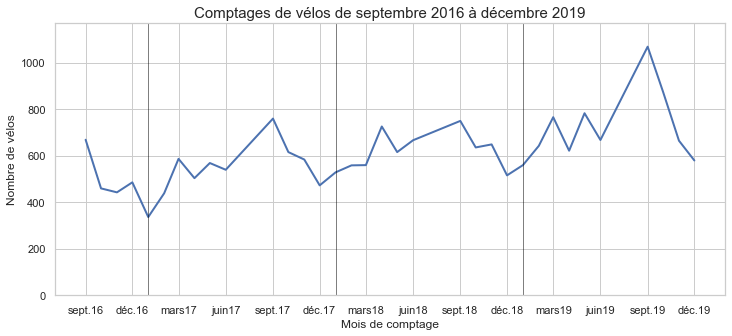

In [24]:
plt.figure(figsize=(12,5))
g_by_month = sns.lineplot(x=ts_by_month.index, y='nombre', data=ts_by_month, linewidth=2)

g_by_month.set(xlabel='Mois de comptage', ylabel='Nombre de vélos')
g_by_month.axes.set_title(base_titre,fontsize=15)

g_by_month.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
g_by_month.xaxis.set_major_formatter(mdates.DateFormatter('%b%y'))
plt.ylim(0, ts_by_month.nombre.max()+100)

for an in lim_annees: 
    plt.axvline(an, linewidth=0.5, color="black")


### Décomposition de la série temporelle

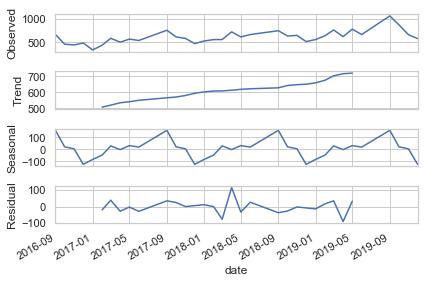

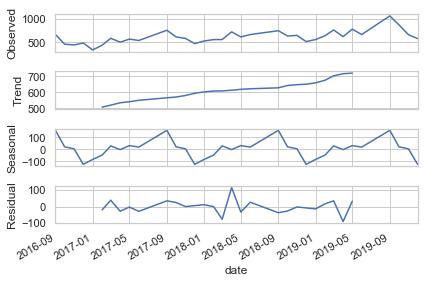

In [25]:
ts_by_month_decompose = seasonal_decompose(ts_by_month, model='additive',freq=10)
ts_by_month_decompose.plot()

### Tendance de l'évolution des comptages

In [26]:
#extraire les 1ère et dernière valeurs de la trend pour les afficher sur le graph
trend1 = ts_by_month_decompose.trend[~np.isnan(ts_by_month_decompose.trend)['nombre']].iloc[0]
trend_der = ts_by_month_decompose.trend[~np.isnan(ts_by_month_decompose.trend)['nombre']].iloc[-1]

In [27]:
#croissance de la tendance
perc_croissance = str(int(round((trend_der.nombre - trend1.nombre)/trend1.nombre*100)))

Text(2019-05-01 00:00:00, 250, '+ 42% de janv.17 à mai.19')

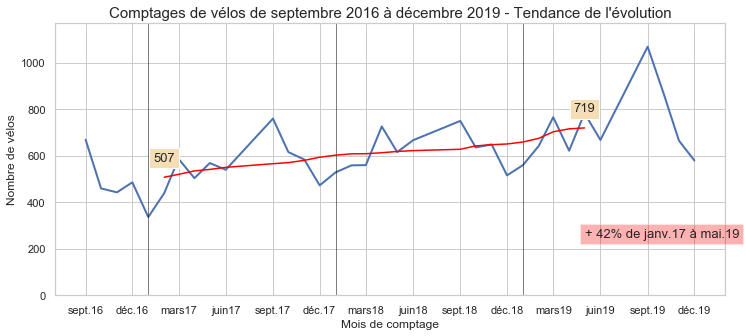

In [28]:
plt.figure(figsize=(12,5))
g_by_month = sns.lineplot(x=ts_by_month.index, y='nombre', data=ts_by_month, linewidth=2)

g_by_month.set(xlabel='Mois de comptage', ylabel='Nombre de vélos')
g_by_month.axes.set_title(base_titre+" - Tendance de l'évolution",fontsize=15)

g_by_month.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
g_by_month.xaxis.set_major_formatter(mdates.DateFormatter('%b%y'))
plt.ylim(0, ts_by_month.nombre.max()+100)

for an in lim_annees: 
    plt.axvline(an, linewidth=0.5, color="black")
    
plt.plot(ts_by_month_decompose.trend,color="red")

g_by_month.text(trend1.name, trend1.nombre+70,int(round(trend1.nombre)), fontsize=13,horizontalalignment='center', bbox=dict(facecolor='wheat'))
g_by_month.text(trend_der.name, trend_der.nombre+70,int(round(trend_der.nombre)), fontsize=13,horizontalalignment='center', bbox=dict(facecolor='wheat'))
g_by_month.text(trend_der.name,250,'+ '+perc_croissance+"% de janv.17 à mai.19", fontsize=13, bbox=dict(facecolor='red',alpha=0.3))


Sur ce graphique, la ligne grise correspond à la courbe des données réelles.

La ligne rouge correspond à la tendance, en enlevant la part liée à la saisonnalité (en réalisant une moyenne glissante sur 12 mois). Cette courbe est en hausse sur la période étudiée (de 507 vélos début 2017 à 719 vélos mi-2019, soit +42%).

On peut donc en déduire qu’en dehors de l’effet « période de l’année », le nombre de vélos comptés connait une forte croissance. 
Attention cependant, cela peut être lié à l’augmentation du nombre de points de mesure.

La moyenne par lieu de comptage permet d’annuler l’effet du nombre de lieux mesurés (cela montre l’évolution du nombre de vélos recensés à nombre égal de rues étudiées).

### Nombre moyen de vélos par comptage

In [29]:
# série temporelle du nombre de vélo moyen (par lieu et voie) compté par mois
data_by_month_tot_velos = data_adava.groupby(['date','lieu','dir_voie'],as_index=False).sum()
#data_by_month_tot_velos = data_adava.groupby(['date','lieu'],as_index=False).sum()
data_by_month_mean = data_by_month_tot_velos.groupby(['date'],as_index=False).mean()
ts_by_month_mean = data_by_month_mean.set_index('date')

#décomposition de la série temporelle
ts_by_month_mean_decompose = seasonal_decompose(ts_by_month_mean, model='additive',freq=10)

#extraire les 1ère et dernière valeurs de la trend pour les afficher sur le graph
trend1 = ts_by_month_mean_decompose.trend[~np.isnan(ts_by_month_mean_decompose.trend)['nombre']].iloc[0]
trend_der = ts_by_month_mean_decompose.trend[~np.isnan(ts_by_month_mean_decompose.trend)['nombre']].iloc[-1]

#croissance de la tendance
perc_croissance = str(int(round((trend_der.nombre - trend1.nombre)/trend1.nombre*100)))

Text(2019-05-01 00:00:00, 6, '+ 33% de janv.17 à mai.19')

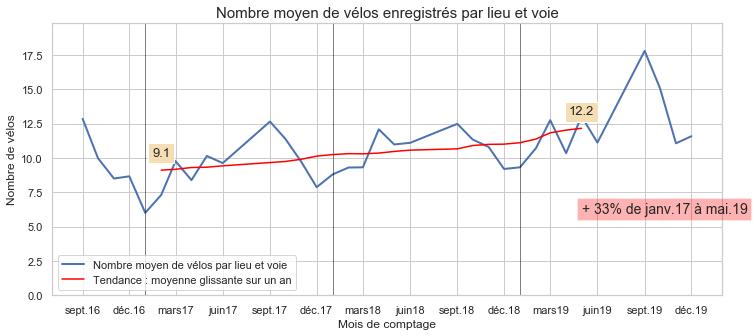

In [109]:
plt.figure(figsize=(12,5))
g_by_month_mean = sns.lineplot(x=ts_by_month_mean.index, y='nombre', data=ts_by_month_mean, linewidth=2,
                               label="Nombre moyen de vélos par lieu et voie")

g_by_month_mean.set(xlabel='Mois de comptage', ylabel='Nombre de vélos')
g_by_month_mean.axes.set_title("Nombre moyen de vélos enregistrés par lieu et voie",fontsize=15)

g_by_month_mean.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
g_by_month_mean.xaxis.set_major_formatter(mdates.DateFormatter('%b%y'))
plt.ylim(0, ts_by_month_mean.nombre.max()+2)

for an in lim_annees: 
    plt.axvline(an, linewidth=0.5, color="black")
    
plt.plot(ts_by_month_mean_decompose.trend,color="red", label='Tendance : moyenne glissante sur un an')
plt.legend(loc='lower left')

g_by_month_mean.text(trend1.name, trend1.nombre+1,round(trend1.nombre,1), fontsize=13,horizontalalignment='center', bbox=dict(facecolor='wheat'))
g_by_month_mean.text(trend_der.name, trend_der.nombre+1,round(trend_der.nombre,1), fontsize=13,horizontalalignment='center', bbox=dict(facecolor='wheat'))
g_by_month_mean.text(trend_der.name,6,'+ '+perc_croissance+"% de janv.17 à mai.19", fontsize=14, bbox=dict(facecolor='red',alpha=0.3))


La ligne grise correspond à la courbe des données réelles et la ligne rouge à la tendance, hors saisonnalité. 

La tendance est là encore en hausse sur la période étudiée, de 9,1 vélos/lieu&voie début 2017 à 12,2 mi-2019, soit +33%.

La hausse est ainsi légèrement moins forte en enlevant l’effet « nombre de lieux de comptage », mais la tendance du nombre de vélos comptés est tout de même toujours en hausse.

#### Saisonnalité

In [31]:
ts_saisonnalite = ts_by_month_mean_decompose.seasonal + ts_by_month_mean.mean()

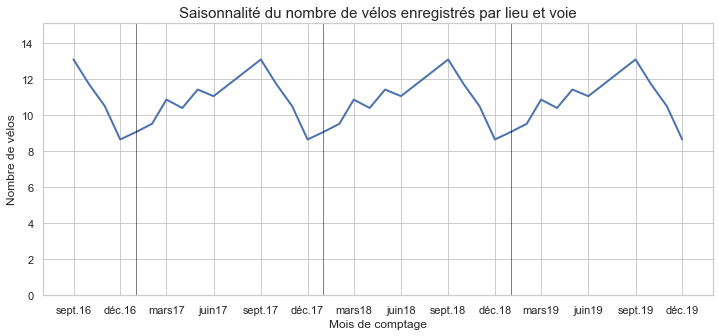

In [32]:
plt.figure(figsize=(12,5))
g_by_month_mean_sais = sns.lineplot(x=ts_saisonnalite.index, y='nombre', data=ts_saisonnalite, linewidth=2)

g_by_month_mean_sais.set(xlabel='Mois de comptage', ylabel='Nombre de vélos')
g_by_month_mean_sais.axes.set_title("Saisonnalité du nombre de vélos enregistrés par lieu et voie",fontsize=15)

g_by_month_mean_sais.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
g_by_month_mean_sais.xaxis.set_major_formatter(mdates.DateFormatter('%b%y'))
plt.ylim(0, ts_saisonnalite.nombre.max()+2)

for an in lim_annees: 
    plt.axvline(an, linewidth=0.5, color="black")

In [33]:
saisonnalite = ts_by_month_mean_decompose.seasonal.iloc[4:14]
saisonnalite.set_index([['Janvier','Février','Mars','Avril','Mai','Juin','Septembre','Octobre','Novembre','Décembre']],inplace=True)

Text(5.5, -2.7, 'Pas de comptages \nen juillet/août')

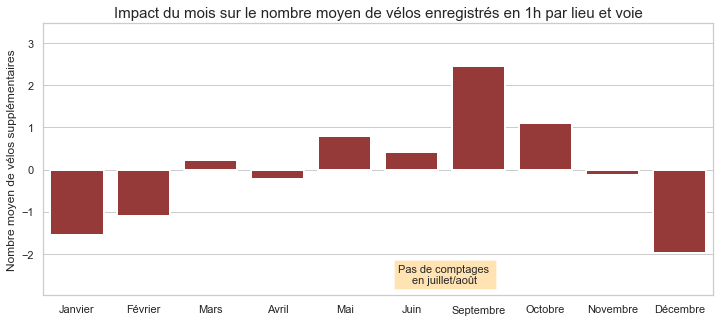

In [34]:
plt.figure(figsize=(12,5))
g_by_month_mean_season = sns.barplot(x=saisonnalite.index, y='nombre', data=saisonnalite, linewidth=2,color='brown')

g_by_month_mean_season.set(xlabel='', ylabel='Nombre moyen de vélos supplémentaires')
g_by_month_mean_season.axes.set_title("Impact du mois sur le nombre moyen de vélos enregistrés en 1h par lieu et voie",fontsize=15)

plt.ylim(saisonnalite.nombre.min()-1, saisonnalite.nombre.max()+1)

g_by_month_mean_season.text(5.5,-2.7,'Pas de comptages \nen juillet/août',fontsize=11,horizontalalignment='center', bbox=dict(facecolor='orange',alpha=0.3))

In [35]:
#en ajoutant le nombre de vélos moyens qui passent
saisonnalite_val = saisonnalite + ts_by_month_mean.mean()

Text(9, nombre    10.917903
dtype: float64, 'Moyenne')

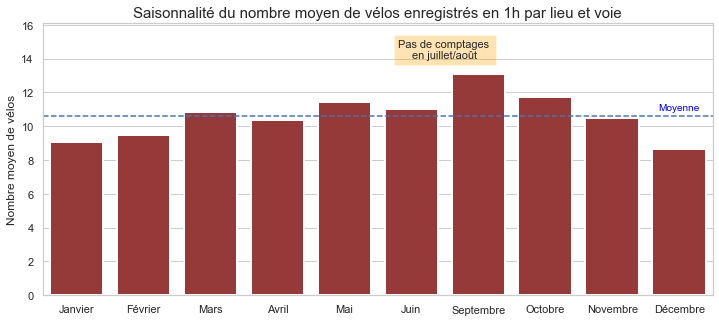

In [36]:
plt.figure(figsize=(12,5))
g_by_month_mean_season_val = sns.barplot(x=saisonnalite_val.index, y='nombre', data=saisonnalite_val, linewidth=2,color='brown')

g_by_month_mean_season_val.set(xlabel='', ylabel='Nombre moyen de vélos')
g_by_month_mean_season_val.axes.set_title("Saisonnalité du nombre moyen de vélos enregistrés en 1h par lieu et voie",fontsize=15)

plt.ylim(0, saisonnalite_val.nombre.max()+3)

g_by_month_mean_season_val.text(5.5,14,'Pas de comptages \nen juillet/août',fontsize=11,horizontalalignment='center', bbox=dict(facecolor='orange',alpha=0.3))

g_by_month_mean_season_val.axhline(ts_by_month_mean.mean().nombre, ls='--')
g_by_month_mean_season_val.text(9,ts_by_month_mean.mean()+0.3,'Moyenne',fontsize=10,horizontalalignment='center', color='blue')


### Nombre de vélos recensés par type de vélo

In [37]:
# série temporelle du nombre de vélo moyen (par lieu et voie) compté par mois
data_by_month_type_mean = data_adava.groupby(['date','type_velo'],as_index=False).mean()
ts_by_month_type_mean = data_by_month_type_mean.set_index('date')

#décomposition de la série temporelle
ts_by_month_type_mean_p = ts_by_month_type_mean.pivot(columns='type_velo', values='nombre')
ts_by_month_type_mean_decompose = seasonal_decompose(ts_by_month_type_mean_p, model='additive',freq=10)

#extraire les 1ère et dernière valeurs de la trend 
trend1_vae = ts_by_month_type_mean_decompose.trend['VAE'][~np.isnan(ts_by_month_type_mean_decompose.trend['VAE'])].iloc[0]
trend_der_vae = ts_by_month_type_mean_decompose.trend['VAE'][~np.isnan(ts_by_month_type_mean_decompose.trend['VAE'])].iloc[-1]
trend1_velo = ts_by_month_type_mean_decompose.trend['Vélos'][~np.isnan(ts_by_month_type_mean_decompose.trend['Vélos'])].iloc[0]
trend_der_velo = ts_by_month_type_mean_decompose.trend['Vélos'][~np.isnan(ts_by_month_type_mean_decompose.trend['Vélos'])].iloc[-1]
trend_date_der = ts_by_month_type_mean_decompose.trend['Vélos'][~np.isnan(ts_by_month_type_mean_decompose.trend['Vélos'])].index[-1]

#croissance de la tendance
perc_croissance_vae = str(int(round((trend_der_vae - trend1_vae)/trend1_vae*100)))
perc_croissance_velo = str(int(round((trend_der_velo - trend1_velo)/trend1_velo*100)))

Text(2019-05-01 00:00:00, 3.2555829228243027, '+ 123% de VAE')

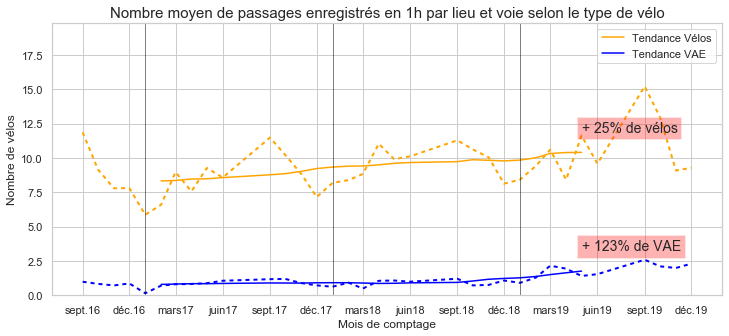

In [38]:
plt.figure(figsize=(12,5))
g_by_month_type_mean = sns.lineplot(x=ts_by_month_type_mean.index, y='nombre', data=ts_by_month_type_mean, hue='type_velo', 
                                    linewidth=2,style='type_velo',dashes=[(2, 2), (2, 2)], palette=["blue","orange"],legend=False)

plt.plot(ts_by_month_type_mean_decompose.trend['Vélos'],color="orange",label="Tendance Vélos")
plt.plot(ts_by_month_type_mean_decompose.trend['VAE'],color="blue",label="Tendance VAE")

plt.legend()

g_by_month_type_mean.set(xlabel='Mois de comptage', ylabel='Nombre de vélos')
g_by_month_type_mean.axes.set_title("Nombre moyen de passages enregistrés en 1h par lieu et voie selon le type de vélo",fontsize=15)

g_by_month_type_mean.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
g_by_month_type_mean.xaxis.set_major_formatter(mdates.DateFormatter('%b%y'))
plt.ylim(0, ts_by_month_mean.nombre.max()+2)

for an in lim_annees: 
    plt.axvline(an, linewidth=0.5, color="black")
    
g_by_month_type_mean.text(trend_date_der,trend_der_velo+1.5,'+ '+perc_croissance_velo+"% de vélos", fontsize=14, bbox=dict(facecolor='red',alpha=0.3))
g_by_month_type_mean.text(trend_date_der,trend_der_vae+1.5,'+ '+perc_croissance_vae+"% de VAE", fontsize=14, bbox=dict(facecolor='red',alpha=0.3))

    

### Nombre de vélos recensés par lieu

In [39]:
# série temporelle du nombre de vélo moyen (par lieu et voie) compté par mois
data_by_month_lieu_mean = data_adava.groupby(['date','lieu'],as_index=False).mean()
ts_by_month_lieu_mean = data_by_month_lieu_mean.set_index('date')

ts_by_month_lieu_mean_p = ts_by_month_lieu_mean.pivot(columns='lieu', values='nombre')


In [40]:
#imputation des données manquantes
#choix : calculer la moyenne annuelle (+/- 6 mois) sur ce lieu et ajouter la composante saisonnière calculée plus haut (saisonnalite)
ts_by_month_lieu_mean_imp = ts_by_month_lieu_mean_p

for lieu1 in ts_by_month_lieu_mean_p.columns:
    for date1 in ts_by_month_lieu_mean_p.index:
        if np.isnan(ts_by_month_lieu_mean_p.loc[date1,lieu1]):
            moy_an_lieu = ts_by_month_lieu_mean_p.loc[(date1-relativedelta(months=7)):(date1+relativedelta(months=7)),lieu1].mean()
            sais_mois = ts_by_month_mean_decompose.seasonal.loc[date1]
            ts_by_month_lieu_mean_imp.loc[date1,lieu1] = round(moy_an_lieu + sais_mois,3).nombre

In [41]:
#décomposition de la série temporelle
ts_by_month_lieu_mean_decompose = seasonal_decompose(ts_by_month_lieu_mean_imp, model='additive',freq=10)

In [42]:
liste_lieux = ts_by_month_lieu_mean_decompose.trend.columns

In [43]:
#calcul des croissances de la tendance
list_perc_croissance = []

#date de la dernière trend dispo
trend_date_der = ts_by_month_lieu_mean_decompose.trend[~np.isnan(ts_by_month_lieu_mean_decompose.trend.iloc[:,0])].index[-1]

for lieu_l in liste_lieux:
    #première et dernière données de la trend
    trend1_l = ts_by_month_lieu_mean_decompose.trend[lieu_l][~np.isnan(ts_by_month_lieu_mean_decompose.trend[lieu_l])].iloc[0]
    trend_der_l = ts_by_month_lieu_mean_decompose.trend[lieu_l][~np.isnan(ts_by_month_lieu_mean_decompose.trend[lieu_l])].iloc[-1]
    
    #% de croissance
    perc_croissance_l = str(int(round((trend_der_l - trend1_l)/trend1_l*100)))
    list_perc_croissance.append(perc_croissance_l)
    

Text(0.5, 0.98, 'Nombre moyen de vélos enregistrés par comptage, par lieu et voie')

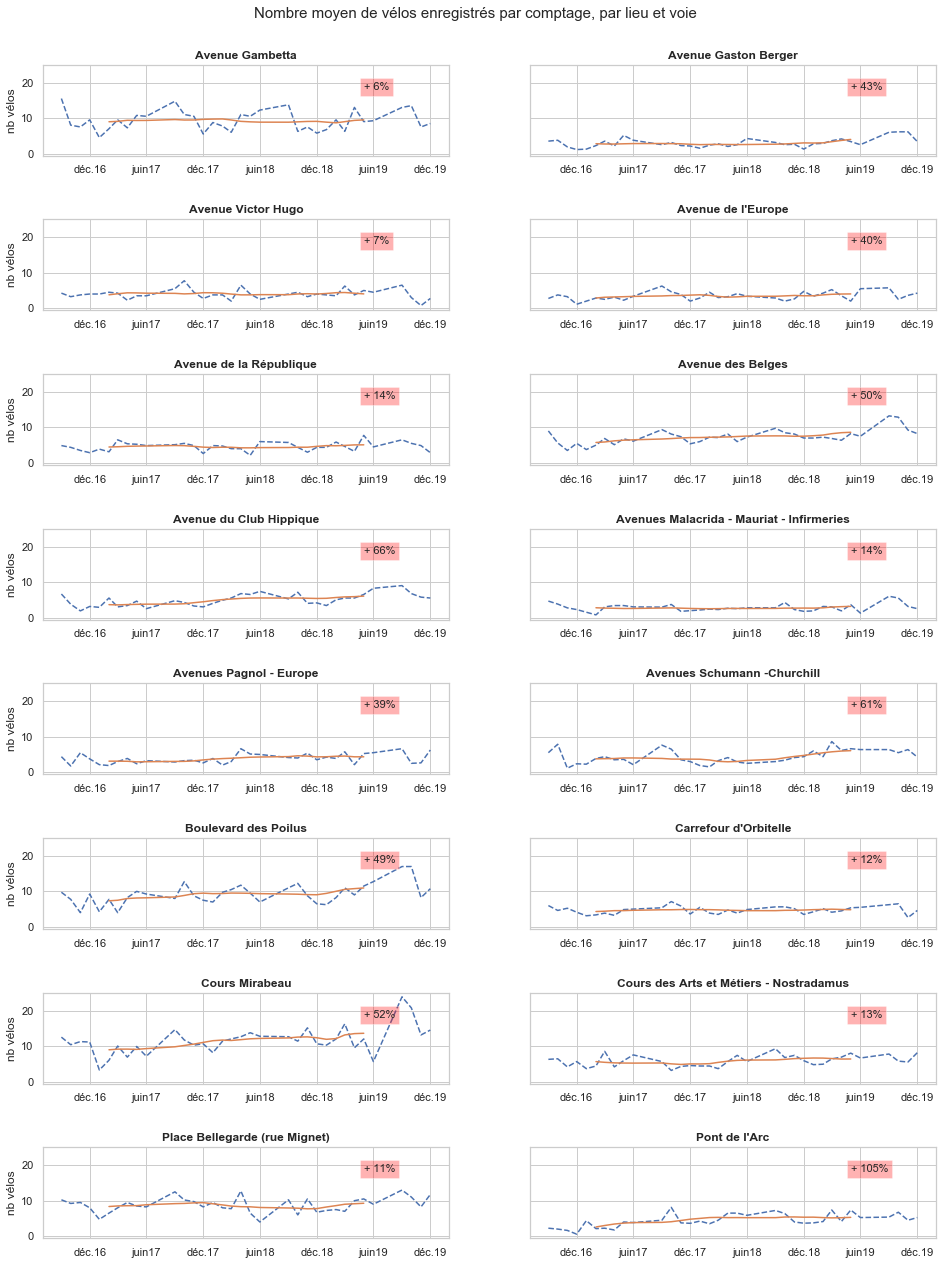

In [44]:
fig, axs = plt.subplots(8,2, sharey = True, figsize=(16, 20))
fig.subplots_adjust(hspace=0.7)
fig.subplots_adjust(top=0.94)

for nlieu in range(16):
    cote = 0 if nlieu%2==0 else 1 #graphs pairs à gauche, impairs à droite
    
    #graph des comptages sur ce lieu
    g=sns.lineplot(x=ts_by_month_lieu_mean_imp.index, y=ts_by_month_lieu_mean_imp.iloc[:,nlieu], ax=axs[nlieu//2,cote]) #comptages de vélos en pointillés
    g.lines[0].set_linestyle("--")

    #ligne de tendance
    sns.lineplot(x=ts_by_month_lieu_mean_decompose.trend.index, y=ts_by_month_lieu_mean_decompose.trend.iloc[:,nlieu], ax=axs[nlieu//2,cote]) #tendance en rouge
    
    #titre et axes
    g.set_title(ts_by_month_lieu_mean_imp.columns[nlieu], weight='bold')
    g.set(xlabel='', ylabel='nb vélos')
    g.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    g.xaxis.set_major_formatter(mdates.DateFormatter('%b%y'))

    #ajouter le % de croissance sur ce lieu
    g.text(trend_date_der,18,'+ '+list_perc_croissance[nlieu]+"%", fontsize=11, bbox=dict(facecolor='red',alpha=0.3))

fig.suptitle('Nombre moyen de vélos enregistrés par comptage, par lieu et voie', fontsize=15)

In [45]:
'''
plt.figure(figsize=(10,4))
g_by_month_lieu_mean = sns.FacetGrid(data_by_month_lieu_mean, col="lieu", col_wrap=4, hue_kws={"ls":["--"]})
g_by_month_lieu_mean.map(plt.plot, "date", "nombre")

g_by_month_lieu_mean.set_titles("{col_name}")
g_by_month_lieu_mean.set_ylabels('Nb de vélos')

plt.subplots_adjust(top=0.92)
g_by_month_lieu_mean.fig.suptitle('Nombre moyen de passages enregistrés par comptage', fontsize=15)

g_by_month_lieu_mean.set(xticks=lim_annees)
g_by_month_lieu_mean.set_xticklabels(lim_annees.year)
'''

'\nplt.figure(figsize=(10,4))\ng_by_month_lieu_mean = sns.FacetGrid(data_by_month_lieu_mean, col="lieu", col_wrap=4, hue_kws={"ls":["--"]})\ng_by_month_lieu_mean.map(plt.plot, "date", "nombre")\n\ng_by_month_lieu_mean.set_titles("{col_name}")\ng_by_month_lieu_mean.set_ylabels(\'Nb de vélos\')\n\nplt.subplots_adjust(top=0.92)\ng_by_month_lieu_mean.fig.suptitle(\'Nombre moyen de passages enregistrés par comptage\', fontsize=15)\n\ng_by_month_lieu_mean.set(xticks=lim_annees)\ng_by_month_lieu_mean.set_xticklabels(lim_annees.year)\n'

## 3 - Graphs comptages mairie

In [46]:
data_mairie_1h.head()

,Av.Schuman,Av.Europe,Av.Belges-dir.Gare,Av.Belges-dir.Rotonde
date,,,,
2019-09-18 02:00:00,NaN,NaN,NaN,2.0
2019-09-18 11:00:00,NaN,NaN,NaN,0.0
2019-09-18 12:00:00,NaN,NaN,NaN,2.0
2019-09-18 13:00:00,NaN,NaN,NaN,29.0
2019-09-18 14:00:00,NaN,NaN,NaN,20.0


#### Aggrégation par jour

In [47]:
#agrégation par jour
data_mairie_j = data_mairie_1h.groupby(data_mairie_1h.index.date).sum()

#supprimer les 2 premiers jours (installation) et le dernier (incomplet)
data_mairie_j = data_mairie_j.drop(data_mairie_j.index[[0,1,-1]])

(0, 335.0)

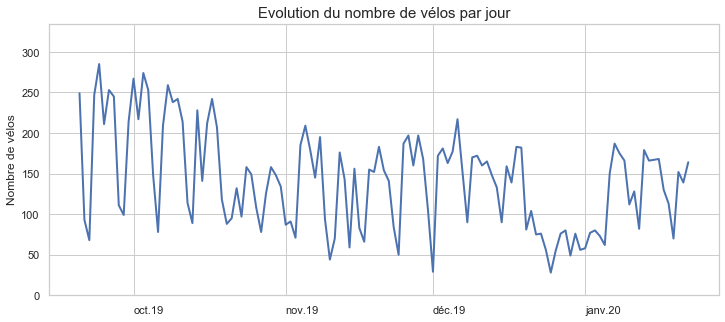

In [48]:
plt.figure(figsize=(12,5))
g_by_lieu = sns.lineplot(x=data_mairie_j.index, y='Av.Schuman', data=data_mairie_j, linewidth=2)

g_by_lieu.set(ylabel='Nombre de vélos')
g_by_lieu.axes.set_title('Evolution du nombre de vélos par jour',fontsize=15)

g_by_lieu.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
g_by_lieu.xaxis.set_major_formatter(mdates.DateFormatter('%b%y'))

for label in g_by_lieu.get_xticklabels():
    label.set_horizontalalignment('left')

plt.ylim(0, data_mairie_j['Av.Schuman'].max()+50)



(0, 550.0)

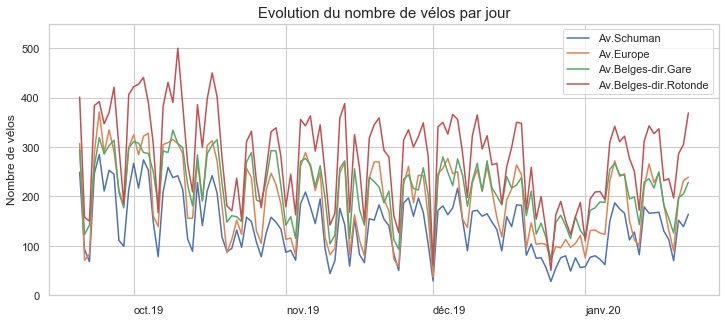

In [49]:
plt.figure(figsize=(12,5))
g_by_lieu = sns.lineplot(data=data_mairie_j,dashes=False)

g_by_lieu.set(ylabel='Nombre de vélos')
g_by_lieu.axes.set_title('Evolution du nombre de vélos par jour',fontsize=15)

g_by_lieu.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
g_by_lieu.xaxis.set_major_formatter(mdates.DateFormatter('%b%y'))

for label in g_by_lieu.get_xticklabels():
    label.set_horizontalalignment('left')

plt.ylim(0, data_mairie_j.max().max()+50)


In [50]:
#agrégation par semaine
data_mairie_s = data_mairie_1h.resample('W-Mon',label='left',closed='left').sum()

#supprimer la 1e et la dernière semaine (incomplètes)
data_mairie_s = data_mairie_s.drop(data_mairie_s.index[[0,-1]])

(0, 2963.0)

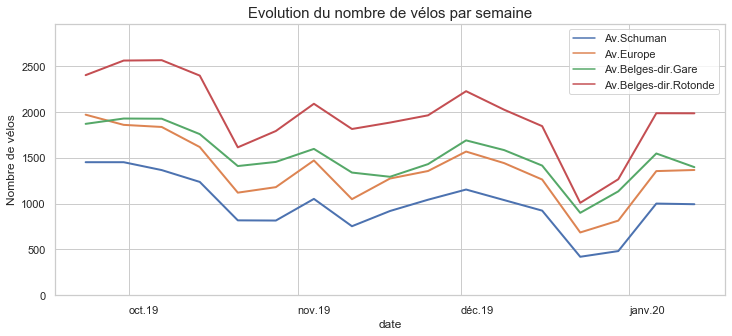

In [51]:
plt.figure(figsize=(12,5))
g_by_lieu_s = sns.lineplot(data=data_mairie_s, linewidth=2,dashes=False)

g_by_lieu_s.set(ylabel='Nombre de vélos')
g_by_lieu_s.axes.set_title('Evolution du nombre de vélos par semaine',fontsize=15)

g_by_lieu_s.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
g_by_lieu_s.xaxis.set_major_formatter(mdates.DateFormatter('%b%y'))

for label in g_by_lieu_s.get_xticklabels():
    label.set_horizontalalignment('left')
    
plt.ylim(0, data_mairie_s.max().max()+400)



#### Nombre total par semaine

In [52]:
data_sem_tot = data_mairie_s.sum(axis=1)

(0, 8795.0)

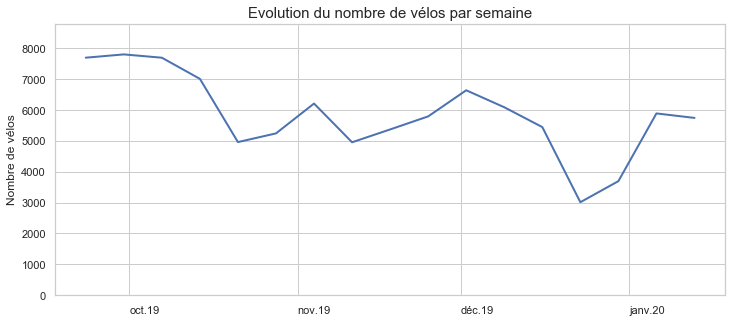

In [53]:
plt.figure(figsize=(12,5))
g_by_lieu_s = sns.lineplot(data=data_sem_tot, linewidth=2)

g_by_lieu_s.set(ylabel='Nombre de vélos')
g_by_lieu_s.axes.set_title('Evolution du nombre de vélos par semaine',fontsize=15)

g_by_lieu_s.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
g_by_lieu_s.xaxis.set_major_formatter(mdates.DateFormatter('%b%y'))

for label in g_by_lieu_s.get_xticklabels():
    label.set_horizontalalignment('left')

plt.ylim(0, data_sem_tot.max()+1000)

## 4 - Comparaison des données de l'ADAVA et de la mairie aux mêmes points

#### Dates et horaires des comptages de l'ADAVA de septembre 2019 à janvier 2020

In [54]:
dates_comptages_europe = pd.to_datetime([datetime(2019, 9, 17, 17, 30),datetime(2019, 9, 17, 17, 45),datetime(2019, 9, 17, 18, 0),
                          datetime(2019, 10, 15, 17, 15),datetime(2019, 10, 15, 17, 30),datetime(2019, 10, 15, 17, 45),datetime(2019, 10, 15, 18,0),
                          datetime(2019, 11, 19, 17, 15),datetime(2019, 11, 19, 17, 30),datetime(2019, 11, 19, 17, 45),datetime(2019, 11, 19, 18,0),
                          datetime(2019, 12, 17, 17, 15),datetime(2019, 12, 17, 17, 30),datetime(2019, 12, 17, 17, 45),datetime(2019, 12, 17, 18,0),
                          datetime(2020, 1, 21, 17, 45),datetime(2020, 1, 21, 18, 0)])
#janvier europe début à 17h50

dates_comptages_belges = pd.to_datetime([datetime(2019, 9, 26, 17, 0),datetime(2019, 9, 26, 17, 15),datetime(2019, 9, 26, 17, 30),datetime(2019, 9, 26, 17, 45),
                          datetime(2019, 10, 17, 17,0),datetime(2019, 10, 17, 17, 15),datetime(2019, 10, 17, 17, 30),datetime(2019, 10, 17, 17, 45),
                          datetime(2019, 11, 12, 17,0),datetime(2019, 11, 12, 17, 15),datetime(2019, 11, 12, 17, 30),datetime(2019, 11, 12, 17, 45),
                          datetime(2019, 12, 10, 17,0),datetime(2019, 12, 10, 17, 15),datetime(2019, 12, 10, 17, 30),datetime(2019, 12, 10, 17, 45),
                          datetime(2020, 1, 14, 17,0),datetime(2020, 1, 14, 17, 15),datetime(2020, 1, 14, 17, 30),datetime(2020, 1, 14, 17, 45)])

dates_comptages_schuman = pd.to_datetime([datetime(2019, 9, 12, 17, 0),datetime(2019, 9, 12, 17, 15),datetime(2019, 9, 12, 17, 30),datetime(2019, 9, 12, 17, 45),
                          datetime(2019, 10, 17, 17,0),datetime(2019, 10, 17, 17, 15),datetime(2019, 10, 17, 17, 30),datetime(2019, 10, 17, 17, 45),
                          datetime(2019, 11, 12, 17,0),datetime(2019, 11, 12, 17, 15),datetime(2019, 11, 12, 17, 30),
                          datetime(2019, 12, 19, 17,0),datetime(2019, 12, 19, 17, 15),datetime(2019, 12, 19, 17, 30),datetime(2019, 12, 19, 17, 45),
                          datetime(2020, 1, 14, 17,0),datetime(2020, 1, 14, 17, 15),datetime(2020, 1, 14, 17, 30),datetime(2020, 1, 14, 17, 45)])
#novembre schuman début à 16h55

#### Sélectionner parmi les données de la mairie les comptages cumulés sur ces horaires

In [103]:
data_schuman_mairie = data_mairie_15mn['Av.Schuman'].iloc[np.isin(data_mairie_15mn.index,dates_comptages_schuman)]

In [ ]:
data_schuman_mairie.groupby(mois,as_index=False).sum()

#### Extraire les données de comptages à comparer

In [56]:
liste_lieux[[3,5,9]]

Index(['Avenue de l'Europe', 'Avenue des Belges',
       'Avenues Schumann -Churchill'],
      dtype='object', name='lieu')

In [57]:
liste_dates = pd.to_datetime([datetime(2019, 9, 1,0,0,0),datetime(2019, 10, 1,0,0,0),datetime(2019, 11, 1,0,0,0),datetime(2019, 12, 1,0,0,0),datetime(2020, 1, 1,0,0,0)])

In [58]:
#on ne garde que les 3 rues avec comptages automatiques et les dates depuis septembre
data_adava_comp = data_adava.iloc[np.isin(data_adava.lieu,liste_lieux[[3,5,9]]) & np.isin(data_adava.date,liste_dates)]

In [59]:
#on cumule les vélos et VAE
data_adava_comp = data_adava_comp.groupby(['date','lieu','dir_voie'],as_index=False).sum()

In [91]:
#sélectionner les données avec la même direction et voie que les comptages automatiques :
#Avenue des Belges : 'Venant du Centre-Ville : Cyclistes sur le trottoir' & 'Vers le Centre-Ville : Cyclistes sur le trottoir'
#Avenue Schuman : 'Avenue Robert Schumann : Cyclistes allant au Centre-Ville'
#Avenue de l'Europe : 'Venant de la Rotonde : Cyclistes sur le trottoir'

data_lieux_compt_auto = np.where(((data_adava_comp['lieu']=='Avenue des Belges') & (data_adava_comp['dir_voie']=='Vers le Centre-Ville : Cyclistes sur le trottoir'))
                                 | ((data_adava_comp['lieu']=='Avenue des Belges') & (data_adava_comp['dir_voie']=='Venant du Centre-Ville : Cyclistes sur le trottoir'))
                                 | ((data_adava_comp['lieu']=='Avenues Schumann -Churchill') & (data_adava_comp['dir_voie']=='Avenue Robert Schumann : Cyclistes allant au Centre-Ville'))
                                 | ((data_adava_comp['lieu']=='Avenue de l\'Europe') & (data_adava_comp['dir_voie']=='Venant de la Rotonde : Cyclistes sur le trottoir')))

data_adava_comp = data_adava_comp.iloc[data_lieux_compt_auto[0]]

#### Associer la date et l'horaire du comptage avec le nombre de vélos

In [93]:
data_adava_comp.head()

,date,lieu,dir_voie,nombre
1,2019-09-01,Avenue de l'Europe,Venant de la Rotonde : Cyclistes sur le trottoir,20
5,2019-09-01,Avenue des Belges,Venant du Centre-Ville : Cyclistes sur le trot...,19
7,2019-09-01,Avenue des Belges,Vers le Centre-Ville : Cyclistes sur le trottoir,39
8,2019-09-01,Avenues Schumann -Churchill,Avenue Robert Schumann : Cyclistes allant au C...,23
13,2019-10-01,Avenue de l'Europe,Venant de la Rotonde : Cyclistes sur le trottoir,13


In [94]:
dates_comptages_europe

DatetimeIndex(['2019-09-17 17:30:00', '2019-09-17 17:45:00',
               '2019-09-17 18:00:00', '2019-10-15 17:15:00',
               '2019-10-15 17:30:00', '2019-10-15 17:45:00',
               '2019-10-15 18:00:00', '2019-11-19 17:15:00',
               '2019-11-19 17:30:00', '2019-11-19 17:45:00',
               '2019-11-19 18:00:00', '2019-12-17 17:15:00',
               '2019-12-17 17:30:00', '2019-12-17 17:45:00',
               '2019-12-17 18:00:00', '2020-01-21 17:45:00',
               '2020-01-21 18:00:00'],
              dtype='datetime64[ns]', freq=None)

## 5 - Analyse de la fréquentation par plage horaire

### Moyenne horaire sur chaque heure de la semaine

### Moyenne journalière sur chaque jour de la semaine

### Redresser les données ADAVA et déterminer la journée type moyenne

## 6 - Analyse des variations saisonnières

In [ ]:
git remote add origin https://github.com/ElisePupier/ADAVA.git